In [1]:
import pandas as pd

df = pd.read_csv('./data/train.csv')
val_df = pd.read_csv('./data/val.csv')
test_df = pd.read_csv('./data/test.csv')

In [2]:
val_df.drop('ID',axis=1,inplace=True)

In [3]:
val_normal, val_fraud = val_df['Class'].value_counts()
val_contamination = val_fraud / val_normal

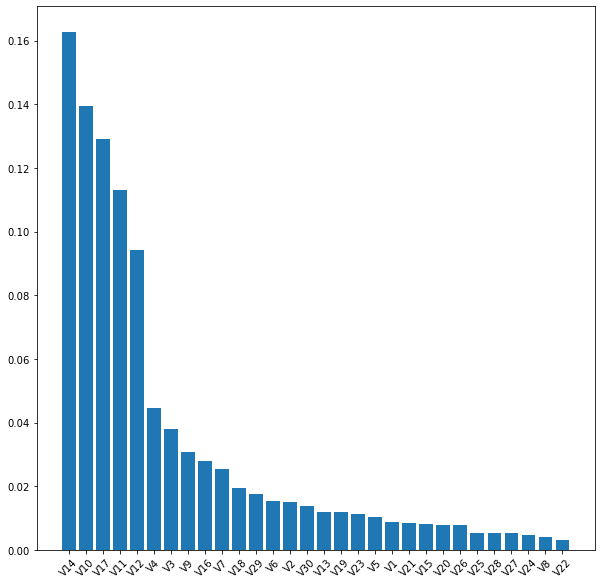

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rnd_clf = RandomForestClassifier(n_estimators = 100 , criterion = 'entropy',random_state = 0)
rnd_clf.fit(val_df.drop('Class',axis=1),val_df['Class'])

importances = rnd_clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.bar(range(val_df.shape[1]-1),importances[indices],align='center')
plt.xticks(range(val_df.shape[1]-1),val_df.drop('Class',axis=1).columns[indices],rotation=45)
plt.show()

In [ ]:
drop_ls = []

for name, importance in zip(val_df.drop('Class',axis=1).columns, rnd_clf.feature_importances_):
    if importance <= 0.020 :
        drop_ls.append(name)
        print('"' + name + '"'+',')

"V1",
"V2",
"V5",
"V6",
"V8",
"V13",
"V15",
"V18",
"V19",
"V20",
"V21",
"V22",
"V23",
"V24",
"V25",
"V26",
"V27",
"V28",
"V29",
"V30",


In [ ]:
test_val_df = val_df.drop(drop_ls,axis=1)

# train

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)

printcipalComponents = pca.fit_transform(val_df.drop(['Class'],axis=1))

principalDf = pd.DataFrame(data=printcipalComponents)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.31596124 0.09027302 0.05780398 0.05107977 0.04761131 0.04350337
 0.04011652 0.02967628 0.02928379 0.02830794 0.02593083 0.0245552
 0.02432153 0.02165253 0.0207517  0.01859561 0.01715708 0.01622516
 0.01594713 0.01526353]
0.9340175023936613


## Local Outlier Factor (LOF)

In [192]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=60, contamination = val_contamination)
y_pred = clf.fit_predict(val_df.drop('Class',axis=1))
y_pred = list(map(lambda x : 1 if x==-1 else 0, y_pred))
n_errors = (y_pred != val_df['Class']).sum()
X_scores = clf.negative_outlier_factor_
n_errors

23

In [77]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=60, contamination = val_contamination)
y_pred = clf.fit_predict(test_val_df)
y_pred = list(map(lambda x : 1 if x==-1 else 0, y_pred))
n_errors = (y_pred != val_df['Class']).sum()
X_scores = clf.negative_outlier_factor_
n_errors

15

In [193]:
lof_pred = y_pred.copy()

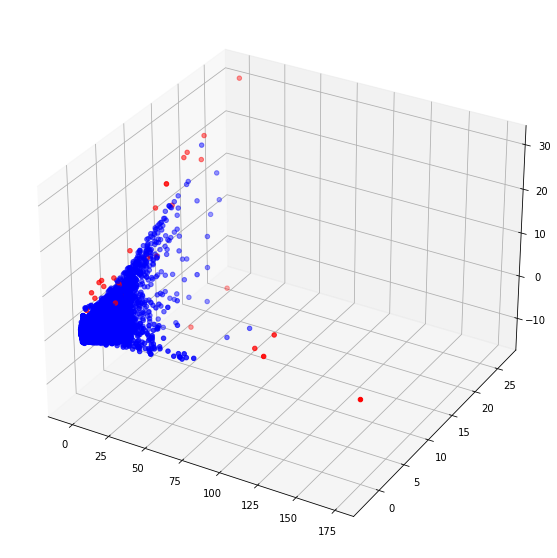

In [194]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(principalDf[0], principalDf[1], principalDf[2],c=list(map(lambda x: 'blue' if x==0 else 'red',lof_pred)))

In [195]:
from sklearn.metrics import f1_score

f1_score(val_df['Class'],lof_pred, average='macro')

0.8112731693633506

In [196]:
ind_ls = []

for ind,i in enumerate(lof_pred != val_df['Class']):
    if i==True:
        ind_ls.append(ind)

In [63]:
ind_ls

[71,
 677,
 1047,
 1210,
 1547,
 4039,
 4917,
 5384,
 5637,
 6350,
 9326,
 12377,
 13706,
 14221,
 15345,
 19002,
 20336,
 20773,
 21895,
 23566,
 24110,
 24273,
 24742,
 25152,
 25504,
 28146,
 28272]

In [64]:
for i in ind_ls:
    print(val_df['Class'][i])

1
1
0
0
1
1
0
0
0
0
1
1
1
1
1
0
0
0
0
0
1
0
1
0
1
1
0


## Isolation Forest

In [125]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)

printcipalComponents = pca.fit_transform(val_df.drop(['Class'],axis=1))

principalDf = pd.DataFrame(data=printcipalComponents)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.31596124 0.09027302 0.05780398 0.05107977 0.04761131 0.04350337
 0.04011652 0.02967628 0.02928379 0.02830794 0.02593083 0.0245552
 0.02432153 0.02165253 0.0207517  0.01859561 0.01715708 0.01622516
 0.01594713 0.01526353]
0.9340175023936609


In [97]:
from sklearn.ensemble import IsolationForest

# isofo = IsolationForest(n_estimators = 1050, max_features = 1.0, max_samples=1.0, 
#                          bootstrap=False, random_state=22,
#                         contamination = val_contamination)

isofo = IsolationForest(n_estimators = 100, max_samples=0.25, 
                         bootstrap=False, random_state=7,
                        contamination = val_contamination,n_jobs=-1)

y_pred = isofo.fit_predict(val_df.drop('Class',axis=1))
y_pred = list(map(lambda x : 1 if x==-1 else 0, y_pred))
n_errors = (y_pred != val_df['Class']).sum()
print(n_errors)

39


In [76]:
from sklearn.ensemble import IsolationForest

isofo = IsolationForest(n_estimators = 100, max_samples=0.25, 
                         bootstrap=False, random_state=7,
                        contamination = val_contamination,n_jobs=-1)

y_pred = isofo.fit_predict(test_val_df)
y_pred = list(map(lambda x : 1 if x==-1 else 0, y_pred))
n_errors = (y_pred != val_df['Class']).sum()
print(n_errors)

13


In [98]:
if_pred = y_pred.copy()

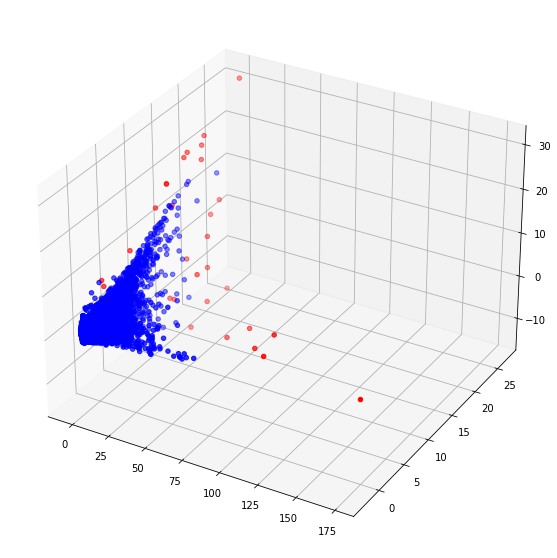

In [173]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(principalDf[0], principalDf[1], principalDf[2],c=list(map(lambda x: 'blue' if x==0 else 'red',if_pred)))

In [99]:
# F1 Score
f1_score(val_df['Class'],if_pred, average='macro')

0.6799849393552464

In [100]:
ind_ls = []

for ind,i in enumerate(if_pred != val_df['Class']):
    if i==True:
        ind_ls.append(ind)

In [101]:
ind_ls

[71,
 641,
 677,
 696,
 1047,
 1210,
 3055,
 3132,
 3197,
 4039,
 5066,
 5384,
 5637,
 6350,
 7630,
 7702,
 7890,
 9326,
 9810,
 12377,
 12797,
 13706,
 14221,
 15425,
 15531,
 18921,
 19002,
 20336,
 21318,
 21895,
 23050,
 24110,
 24358,
 24742,
 25042,
 25504,
 27159,
 27998,
 28146]

In [70]:
for i in ind_ls:
    print(val_df['Class'][i])

1
1
1
0
0
0
1
0
0
1
0
0
0
0
1
0
1
0
1
1
1
1
1
0
0
0
0
0
0
0
1
1
1
1
1
0
0
1
1


## EllipticEnvelope

In [142]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

printcipalComponents = pca.fit_transform(val_df.drop(['Class'],axis=1))

principalDf = pd.DataFrame(data=printcipalComponents)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.31596124 0.09027291 0.05780209]
0.46403623548513634


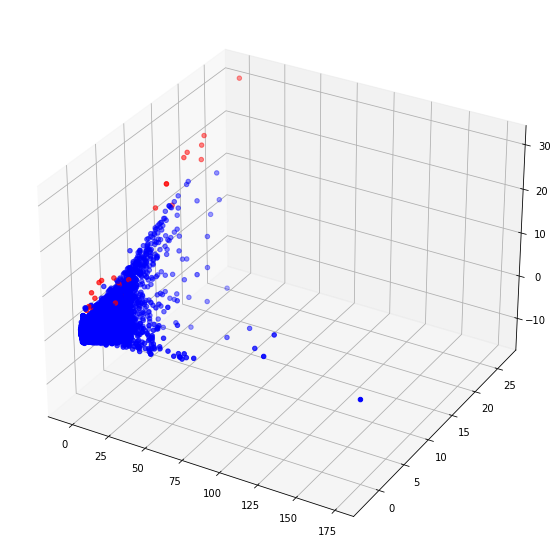

In [159]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(principalDf[0], principalDf[1], principalDf[2],c=val_df['Class'].apply(lambda x: 'blue' if x==0 else 'red'))

<AxesSubplot:xlabel='0', ylabel='1'>

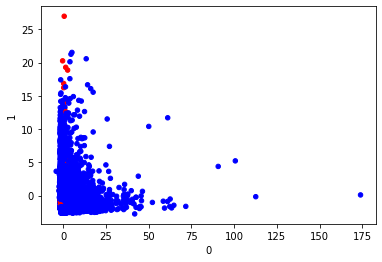

In [162]:
principalDf.plot.scatter(x=0,y=1,c=val_df['Class'].apply(lambda x: 'blue' if x==0 else 'red'))

<AxesSubplot:xlabel='1', ylabel='2'>

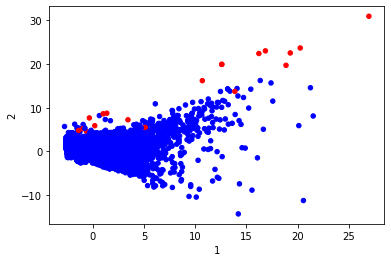

In [148]:
principalDf.plot.scatter(x=1,y=2,c=val_df['Class'].apply(lambda x: 'blue' if x==0 else 'red'))

In [86]:
from sklearn.covariance import EllipticEnvelope

cov = EllipticEnvelope(support_fraction = 1-val_contamination,assume_centered=False, contamination = val_contamination,random_state=777)
ee_pred = cov.fit_predict(val_df)
ee_pred = list(map(lambda x : 0 if x==1 else 1, ee_pred))
n_errors = (ee_pred != val_df['Class']).sum()
print(n_errors)

11


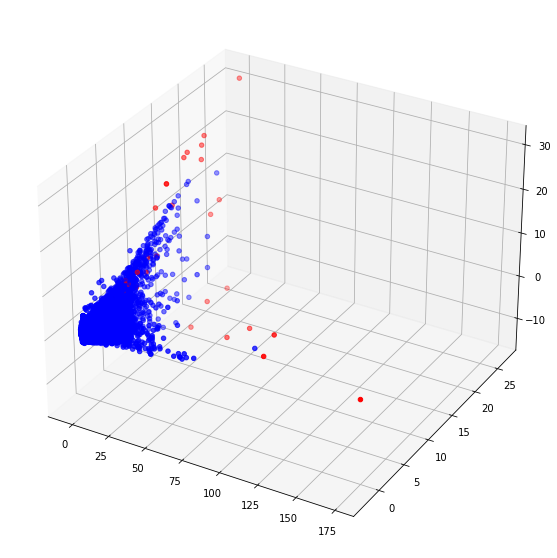

In [172]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(principalDf[0], principalDf[1], principalDf[2],c=list(map(lambda x: 'blue' if x==0 else 'red',ee_pred)))

In [88]:
ind_ls = []

for ind,i in enumerate(ee_pred != val_df['Class']):
    if i==True:
        ind_ls.append(ind)

In [89]:
ind_ls

[71, 1047, 1210, 4039, 7000, 9326, 14221, 15306, 19113, 21318, 28146]

In [75]:
for i in ind_ls:
    print(val_df['Class'][i])

1
0
0
1
0
1
1
0
0
0
1


In [285]:
drop_ls = []

for name, importance in zip(val_df.drop('Class',axis=1).columns, rnd_clf.feature_importances_):
    if importance <= 0.0075 :
        drop_ls.append(name)
        print('"' + name + '"'+',')
print(len(drop_ls))

"V8",
"V22",
"V24",
"V25",
"V27",
"V28",
6


In [286]:
test_val_df = val_df.drop(drop_ls,axis=1)

In [287]:
# 튜닝 부분. test에서 drop_ls 끌어다 사용 중

from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import confusion_matrix

cov = EllipticEnvelope(support_fraction = 0.001, contamination = val_contamination+0.0001,random_state=777)
ee_pred = cov.fit_predict(test_val_df)
ee_pred = list(map(lambda x : 0 if x==1 else 1, ee_pred))
n_errors = (ee_pred != val_df['Class']).sum()
print(n_errors)
print(f1_score(val_df['Class'],ee_pred, average='macro'))
print(pd.DataFrame(ee_pred).value_counts())
print(confusion_matrix(val_df['Class'],ee_pred))

C:\Users\kimji\AppData\Roaming\Python\Python38\site-packages\sklearn\covariance\_empirical_covariance.py:88: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


5
0.960273493450891
0    28429
1       33
dtype: int64
[[28428     4]
 [    1    29]]


## result

In [76]:
ls = []

for i,j,k in zip(lof_pred, if_pred, ee_pred):
    if i*0.3+j*0.2+k*0.5 > 0.7:
        ls.append(1)
    else:
        ls.append(0)

In [77]:
f1_score(val_df['Class'],ls, average='macro')

0.846806907378336

# test

## multivariate_normal

In [ ]:
from scipy.stats import multivariate_normal
import numpy as np

p = multivariate_normal(mean=np.mean(test_df.drop('ID',axis=1),axis=0), cov=np.cov(test_df.drop('ID',axis=1).T))

In [ ]:
eps = 1e-180
x = p.pdf(test_df.drop('ID',axis=1))
mn_pred = (x<=eps)
mn_pred = list(map(lambda x : 0 if x==False else 1, mn_pred))

## Local Outlier Factor (LOF)

In [ ]:
val_normal, val_fraud = val_df['Class'].value_counts()
val_contamination = val_fraud / val_normal

In [ ]:
# fit the model for outlier detection (default)
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=50, contamination = val_contamination)
y_pred = clf.fit_predict(test_df.drop('ID',axis=1))
y_pred = list(map(lambda x : 1 if x==-1 else 0, y_pred))
lof_pred = y_pred.copy()

## Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

isofo = IsolationForest(n_estimators = 125, max_features = 1.0, max_samples=len(test_df.drop('ID',axis=1)), 
                         bootstrap=False, random_state=22,
                        contamination = val_contamination,
                        verbose=0)

y_pred = isofo.fit_predict(test_df.drop('ID',axis=1))
y_pred = list(map(lambda x : 1 if x==-1 else 0, y_pred))
if_pred = y_pred.copy()

## One Class SVM

In [ ]:
from sklearn.svm import OneClassSVM


OneSVM = OneClassSVM(nu = val_contamination)

y_pred = OneSVM.fit_predict(test_df.drop('ID',axis=1))
y_pred = list(map(lambda x : 1 if x==-1 else 0, y_pred))
oc_pred = y_pred.copy()

## EllipticEnvelope

In [ ]:
# from sklearn.covariance import EllipticEnvelope

# cov = EllipticEnvelope(support_fraction = 1,assume_centered=False, contamination = val_contamination,random_state=777)
# ee_pred = cov.fit_predict(test_df.drop('ID',axis=1))
# ee_pred = list(map(lambda x : 0 if x==1 else 1, ee_pred))

In [ ]:
# mn_pred
# lof_pred
# if_pred
# oc_pred
# ee_pred

In [ ]:
# ls = []

# for i,j,k,l,m in zip(mn_pred, lof_pred, if_pred, oc_pred, ee_pred):
#     if i+j+k+l+m > 2:
#         ls.append(1)
#     else:
#         ls.append(0)

In [ ]:
# pd.DataFrame(ls).value_counts()

In [ ]:
# submit = pd.read_csv('./data/sample_submission.csv')
# submit['Class'] = ls
# submit.to_csv('./submit_merge.csv', index=False)

In [128]:
# train 부분에서 튜닝 후 사용.

test_test_df = test_df.drop(drop_ls,axis=1)

In [288]:
from sklearn.covariance import EllipticEnvelope

# cov = EllipticEnvelope(support_fraction = 0.1, contamination = val_contamination,random_state=777)

cov = EllipticEnvelope(support_fraction = 0.001, contamination = val_contamination+0.0002,random_state=777)
ee_pred = cov.fit_predict(test_test_df.drop('ID',axis=1))
ee_pred = list(map(lambda x : 0 if x==1 else 1, ee_pred))

C:\Users\kimji\AppData\Roaming\Python\Python38\site-packages\sklearn\covariance\_empirical_covariance.py:88: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


In [289]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['Class'] = ee_pred
submit.to_csv('./submit_merge_v2_error_plus_ver3.csv', index=False)

In [202]:
pd.read_csv('./submit_merge_v2_error_plus_ver2.csv')['Class'].value_counts()

0    142331
1       172
Name: Class, dtype: int64

In [134]:
pd.read_csv('./submit_merge.csv')['Class'].value_counts()

0    142352
1       151
Name: Class, dtype: int64

In [136]:
pd.read_csv('./submit.csv')['Class'].value_counts()

0    142352
1       151
Name: Class, dtype: int64